In [1]:
!pip install transformers
!pip install tensorflow

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [3]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model

img_A_inp = Input((28,28), name= 'img_A_inp')
img_B_inp = Input((28,28), name= 'img_B_inp')

In [5]:
def cnn_block(depth):
    return Sequential([Conv2D(depth,3,1),
                       BatchNormalization(),
                       ReLU()])

DEPTH=64

cnn = Sequential([Reshape((28,28,1)),
                  cnn_block(DEPTH),
                  cnn_block(DEPTH*2),
                  cnn_block(DEPTH*4),
                  cnn_block(DEPTH*8),
                  GlobalAveragePooling2D(),
                  Dense(64, activation = 'relu')])

feature_vector_A = cnn(img_A_inp)
feature_vector_B = cnn(img_B_inp)

In [6]:
concat = Concatenate()([feature_vector_A, feature_vector_B])

In [7]:
dense = Dense(64, activation = 'relu')(concat)

output = Dense(1, activation = 'sigmoid')(dense)

model = Model(inputs=[img_A_inp, img_B_inp], outputs =output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img_A_inp (InputLayer)      [(None, 28, 28)]             0         []                            
                                                                                                  
 img_B_inp (InputLayer)      [(None, 28, 28)]             0         []                            
                                                                                                  
 sequential_4 (Sequential)   (None, 64)                   1586496   ['img_A_inp[0][0]',           
                                                                     'img_B_inp[0][0]']           
                                                                                                  
 concatenate (Concatenate)   (None, 128)                  0         ['sequential_4[0][0]',    

In [8]:
random_indices = np.random.choice(X_train.shape[0], 300, replace=False)

X_train_sample, y_train_sample = X_train[random_indices], y_train[random_indices]

X_train_sample.shape, y_train_sample.shape

((300, 28, 28), (300,))

In [9]:
len(X_train_sample)**2

90000

In [10]:
import itertools
def make_paired_dataset(X,y):
    X_pairs, y_pairs = [],[]
    tuples = [(x1,y1) for x1,y1 in zip(X,y)]
    for t in itertools.product(tuples, tuples):
        pair_A, pairB=t
        img_A, label_A=t[0]
        img_B, label_B=t[1]
        new_label = int(label_A==label_B)
        X_pairs.append([img_A, img_B])
        y_pairs.append(new_label)

    X_pairs=np.array(X_pairs)
    y_pairs=np.array(y_pairs)
    return X_pairs, y_pairs

In [11]:
make_paired_dataset(X_train_sample, y_train_sample)

(array([[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
 
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
 
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0

In [12]:
X_train_pairs, y_train_pairs = make_paired_dataset(X_train_sample, y_train_sample)

X_train_pairs.shape, y_train_pairs.shape

((90000, 2, 28, 28), (90000,))

In [13]:
random_indices = np.random.choice(X_test.shape[0], 150, replace=False)

X_test_sample, y_test_sample = X_test[random_indices], y_test[random_indices]

X_test_sample.shape, y_test_sample.shape

((150, 28, 28), (150,))

In [14]:
X_test_pairs, y_test_pairs = make_paired_dataset(X_test_sample, y_test_sample)

X_test_pairs.shape, y_test_pairs.shape

((22500, 2, 28, 28), (22500,))

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3)

In [24]:
model.fit(x=[X_train_pairs[:, 0, :, :], X_train_pairs[:, 1, :, :]],
          y=y_train_pairs,
          validation_data=([X_test_pairs[:, 0, :, :], X_test_pairs[:, 1, :, :]], y_test_pairs),
          epochs=2,
          batch_size=32,
          callbacks=[es])   

Epoch 1/2
2813/2813 [==============================] - 2757s 980ms/step - loss: 0.0474 - accuracy: 0.9818 - val_loss: 0.2294 - val_accuracy: 0.9462
Epoch 2/2
2813/2813 [==============================] - 2807s 998ms/step - loss: 0.0112 - accuracy: 0.9962 - val_loss: 0.1557 - val_accuracy: 0.9575


In [40]:
img_A, img_B = X_test[0], X_test[17]
label_A, label_B = y_test[0], y_test[17]
label_A, label_B

(7, 7)

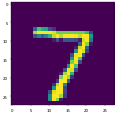

In [41]:
plt.figure(dpi=28)
plt.imshow(img_A)

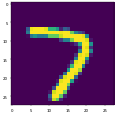

In [42]:
plt.figure(dpi=28)
plt.imshow(img_B)

In [44]:
model.predict([img_A.reshape((1,28,28)),
               img_B.reshape((1,28,28))]).flatten()

1/1 [==============================] - 0s 22ms/step


array([0.9999859], dtype=float32)

In [45]:
model.predict([img_A.reshape((1,28,28)),
               img_B.reshape((1,28,28))]).flatten()[0]>0.8

1/1 [==============================] - 0s 22ms/step


True